In [ ]:
!pip3 install opencv-python
!pip3 install pip install scikit-plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d enesbayturk/vehicle-and-pedestrian-detection-dataset

In [ ]:
#!unzip /content/vehicle-and-pedestrian-detection-dataset.zip -d /content/drive/MyDrive/
import os
for i in os.listdir("/content/drive/MyDrive/Veri Seti/"):
    print(str(len(os.listdir("/content/drive/MyDrive/Veri Seti/"+i))) +" "+ i +" Images")

1856 Bus Images
600 Car Images
228 Lorry Images
701 Motorcycles Images
819 Small Lorry Images
363 Truck Images
849 Van Images
332 Person Images


Bus
10060407.jpg
10060465.jpg
10060411.jpg
10060448.jpg
10060375.jpg
10060464.jpg
10060445.jpg
10060410.jpg
10060459.jpg
10060447.jpg
10060431.jpg
10060409.jpg
10060469.jpg
10060416.jpg
10060405.jpg
10060418.jpg
10060426.jpg
10060460.jpg
10060466.jpg
10060419.jpg
10060403.jpg
10060381.jpg
10060476.jpg
10060441.jpg
10060472.jpg
10060432.jpg
10060435.jpg
10090446.jpg
10060376.jpg
10060442.jpg
Person
1000236.jpg
1000246.jpg
1000244.jpg
1000237.jpg
1000247.jpg
1000250.jpg
1000241.jpg
1000245.jpg
1000235.jpg
1000238.jpg
1000254.jpg
1000249.jpg
1000252.jpg
1000242.jpg
1000243.jpg
1000240.jpg
1000239.jpg
1000253.jpg
1000251.jpg
1000248.jpg
1000256.jpg
1000275.jpg
1000282.jpg
1000408.jpg
1000377.jpg
1000379.jpg
1000378.jpg
1000374.jpg
1000417.jpg
1000384.jpg
['bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'person', 'person', 'person'

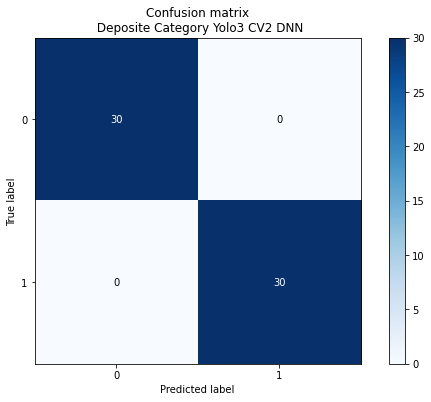

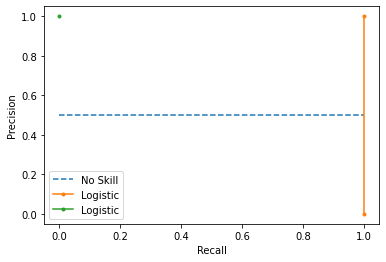

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


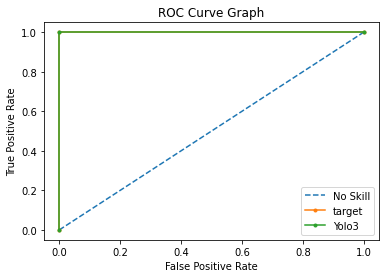

In [ ]:
import scikitplot as skplt
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from google.colab.patches import cv2_imshow
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from scipy import stats  # For in-built method to get PCC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

def detectioninimage(imagepath):
    path2 = os.path.abspath('/content/drive/MyDrive/yolococo/cfg/yolov3.weights')

    # initialize minimum probability to eliminate weak predictions
    p_min = 0.5

    # threshold when applying non-maxia suppression
    thres = 0.3


    # Read image with opencv
    image = cv2.imread(imagepath) # we get image in BGR
    h, w = image.shape[:2]  # Slicing and get height, width of the image

    # image preprocessing for deep learning
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)
    #print(image.shape) # (548, 821, 3)
    #print(blob.shape) # (1, 3, 416, 416)

    # Create labels into list
    with open('/content/drive/MyDrive/yolococo/cfg/coco.names') as f:
        labels = [line.strip() for line in f]

    # Initialize colours for representing every detected object
    colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

    # Loading trained YOLO v3 Objects Detector
    # with the help of 'dnn' library from OpenCV
    # Reads a network model stored in Darknet model files.
    network = cv2.dnn.readNetFromDarknet('/content/drive/MyDrive/yolococo/cfg/yolov3.cfg',
                                         path2)
    
    # Getting only output layer names that we need from YOLO
    ln = network.getLayerNames()
    ln = [ln[i[0] - 1] for i in network.getUnconnectedOutLayers()]
    #print(ln)

    # perform a forward pass of the YOLO object detector, giving us our bounding boxes
    # and associated probabilities.
    network.setInput(blob)
    output_from_network = network.forward(ln)

    # Preparing lists for detected bounding boxes, confidences and class numbers.
    bounding_boxes = []
    confidences = []
    class_numbers = []

    # Going through all output layers after feed forward pass
    for result in output_from_network:
        for detected_objects in result:
            scores = detected_objects[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > p_min:
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                # Now, from YOLO data format, we can get top left corner coordinates
                # that are x_min and y_min
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Adding results into prepared lists
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    #print(bounding_boxes)
    #print(confidences)
    #print(class_numbers)


    # Implementing non-maximum suppression of given bounding boxes
    # With this technique we exclude some of bounding boxes if their
    # corresponding confidences are low or there is another
    # bounding box for this region with higher confidence
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences,
                               p_min, thres)

    # At-least one detection should exists
    predicted_labels =list()
    if len(results) > 0:
        for i in results.flatten():

            # Getting current bounding box coordinates, its width and height
            #x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            #box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

            # Preparing colour for current bounding box
            #colour_box_current = colours[class_numbers[i]].tolist()

            # Drawing bounding box on the original image
            #cv2.rectangle(image, (x_min, y_min),
            #              (x_min + box_width, y_min + box_height),
            #              colour_box_current, 2)

            # Preparing text with label and confidence for current bounding box
            #text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])],
            #                                       confidences[i])
            predicted_labels.append(labels[int(class_numbers[i])])
            # Putting text with label and confidence on the original image
            #cv2.putText(image, text_box_current, (x_min, y_min - 5),
            #            cv2.FONT_HERSHEY_COMPLEX, 0.7, colour_box_current, 2)


    #cv2.namedWindow('Detections', cv2.WINDOW_NORMAL) # WINDOW_NORMAL gives window as resizable.
    #cv2_imshow(image)
    #cv2.waitKey(0)
    #cv2.destroyWindow('Detections')
    return predicted_labels

def ModelPerformance(noofsamples):
  # setting the path where all file's folder are
  root = '/content/drive/MyDrive/Veri Seti/'
  i = 0
  MainFolder="/content/drive/MyDrive/Veri Seti"
  labels=os.listdir(MainFolder)
  labels=['Bus','Person']
  labels1=list()
  for i in range(len(labels)):
    labels1.append(labels[i].lower())
  # Loading the features in the dataframe
  predicted_labels =list()
  target_labels =list()
  for label in labels:
    print(label)
    label1= label.lower()
    folders = os.path.join(root,label)
    items = os.listdir(folders)
    for item in items[:noofsamples]:
      print(item)
      path = os.path.join(folders,item)
      results=detectioninimage(path)
      target_labels.append(label1)
      predicted_labels.append(results[0])
      #print(results[0])
  print(target_labels)
  print(predicted_labels)
  le = preprocessing.LabelEncoder()
  target_labels=le.fit_transform(target_labels)
  predicted_labels=le.fit_transform(predicted_labels)
  target_names = labels
  print(classification_report(target_labels, predicted_labels, target_names=target_names))
  y_test = target_labels
  preds = predicted_labels
  rms = np.sqrt(np.mean(np.power((np.array(y_test) - np.array(preds)), 2)))
  score = r2_score(y_test, preds)
  mae = mean_absolute_error(y_test, preds)
  mse = mean_squared_error(y_test, preds)
  #rms = math.sqrt(mse)
  pearson_coef, p_value = stats.pearsonr(y_test, preds)

  print("root mean square:", rms)
  print("score:", score)
  print("mean absolute error:", mae)
  print("mean squared error:", mse)
  print("pearson_coef:", pearson_coef)
  print("p_value:", p_value)
  print("=======================================================================\n\n")
  ModelName='Yolo3 CV2 DNN'
  skplt.metrics.plot_confusion_matrix(
  y_test,
  preds,
  figsize=(10, 6), title="Confusion matrix\n Deposite Category "+ModelName)
  plt.xlim(-0.5, len(np.unique(y_test)) - 0.5)
  plt.ylim(len(np.unique(y_test)) - 0.5, -0.5)
  plt.savefig('cvroc.png')
  plt.show()

# Bagging
  ns_probs = [0 for _ in range(len(y_test))]
  #lr_probs = predictions
  #best_found_fina=individual_list
  ns_aucb = roc_auc_score(y_test, ns_probs)
  lr_aucb = roc_auc_score(y_test, preds)
  precision, recall, thresholds = precision_recall_curve(y_test, preds)
  no_skill = len(y_test[y_test==1]) / len(y_test)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  plt.plot(precision, recall,thresholds, marker='.', label='Logistic')
# axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
# show the legend
  plt.legend()
# show the plot
  plt.show()
  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_aucb))

  print('Logistic: ROC AUC=%.3f' % (lr_aucb))

    # calculate roc curves
  ns_fprb, ns_tprb, _ = roc_curve(y_test, ns_probs)
  lr_fprb, lr_tprb, _ = roc_curve(y_test, preds)
    # plot the roc curve for the model
  plt.plot(ns_fprb, ns_tprb, linestyle='--', label='No Skill')
  plt.plot(lr_fprb, lr_tprb, marker='.', label='target')
  plt.plot(lr_fprb, lr_tprb, marker='.', label='Yolo3')
    # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
    # show the legend
  plt.legend()
  plt.title("ROC Curve Graph")
  plt.savefig('comparisonroc.png')
    # show the plot
  plt.show()

ModelPerformance(30)

(1365, 2048, 3)
(1, 3, 416, 416)
['yolo_82', 'yolo_94', 'yolo_106']
[[1560, 194, 518, 729], [-7, 338, 436, 617], [508, 473, 382, 748], [2, 359, 406, 585], [352, 529, 190, 213], [540, 548, 138, 305], [948, 572, 131, 286], [592, 413, 261, 839], [833, 455, 252, 728], [1240, 534, 173, 527], [1333, 502, 281, 646], [1646, 491, 279, 650], [1626, 309, 100, 99], [1285, 527, 55, 118]]
[0.574829638004303, 0.9395565390586853, 0.6671983003616333, 0.8802480697631836, 0.9797011017799377, 0.6034567356109619, 0.6612544059753418, 0.993368923664093, 0.9983739852905273, 0.9960762858390808, 0.9969139695167542, 0.9990978837013245, 0.6091744303703308, 0.6571846604347229]
[5, 7, 0, 7, 2, 26, 26, 0, 0, 0, 0, 0, 9, 0]


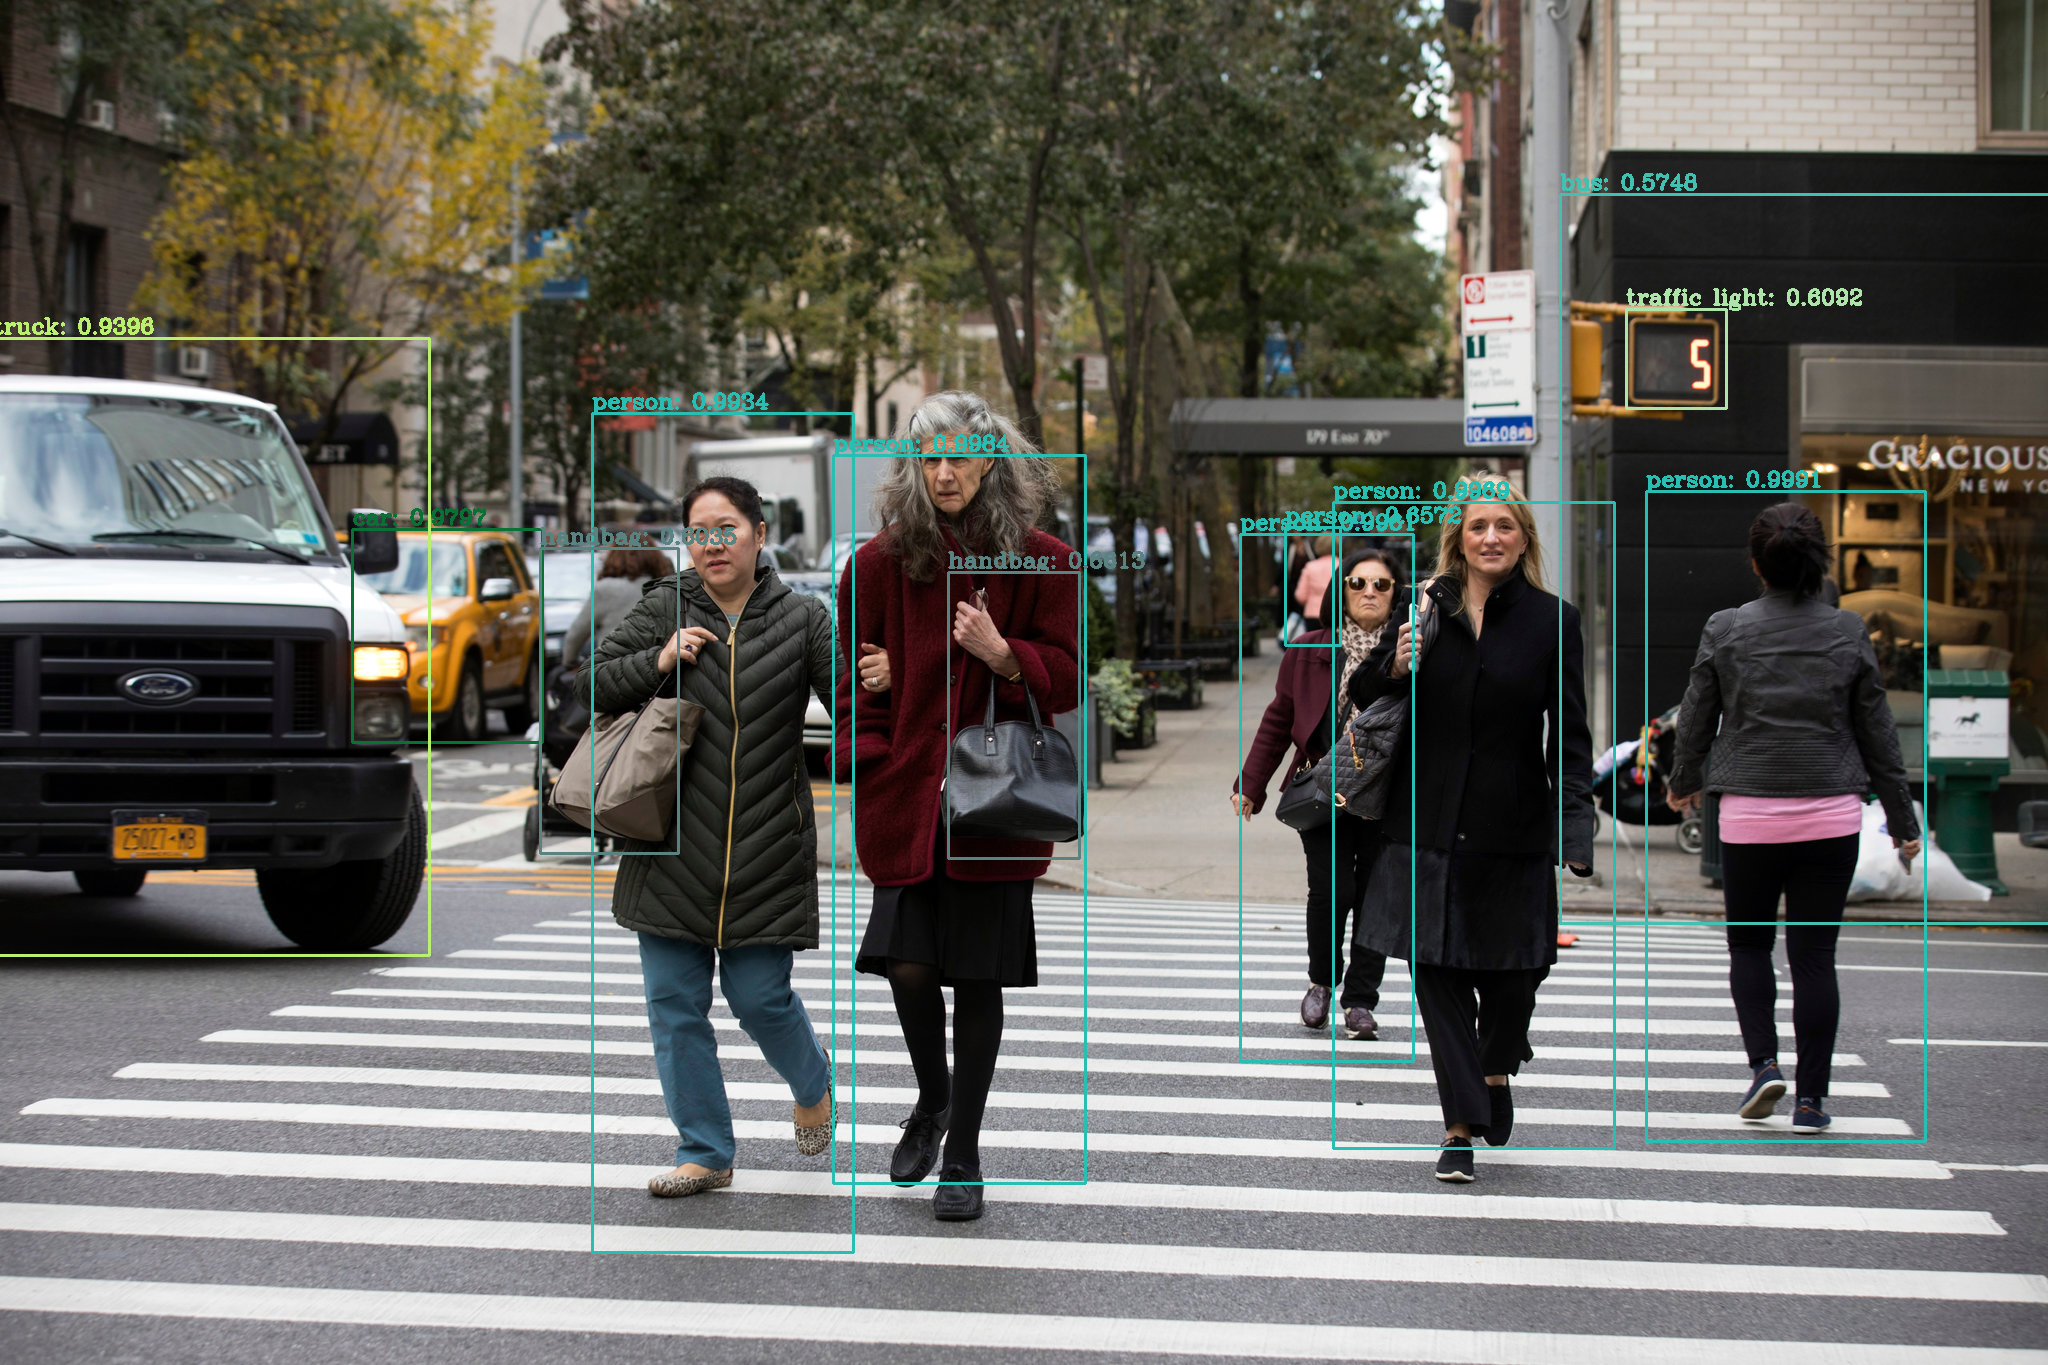

(667, 1000, 3)
(1, 3, 416, 416)
['yolo_82', 'yolo_94', 'yolo_106']
[[382, 172, 280, 355], [106, 271, 320, 266], [371, 44, 599, 658], [649, 397, 78, 120], [320, 620, 145, 30]]
[0.9985329508781433, 0.9969787001609802, 0.9989408254623413, 0.7917543053627014, 0.5135066509246826]
[0, 63, 0, 56, 67]


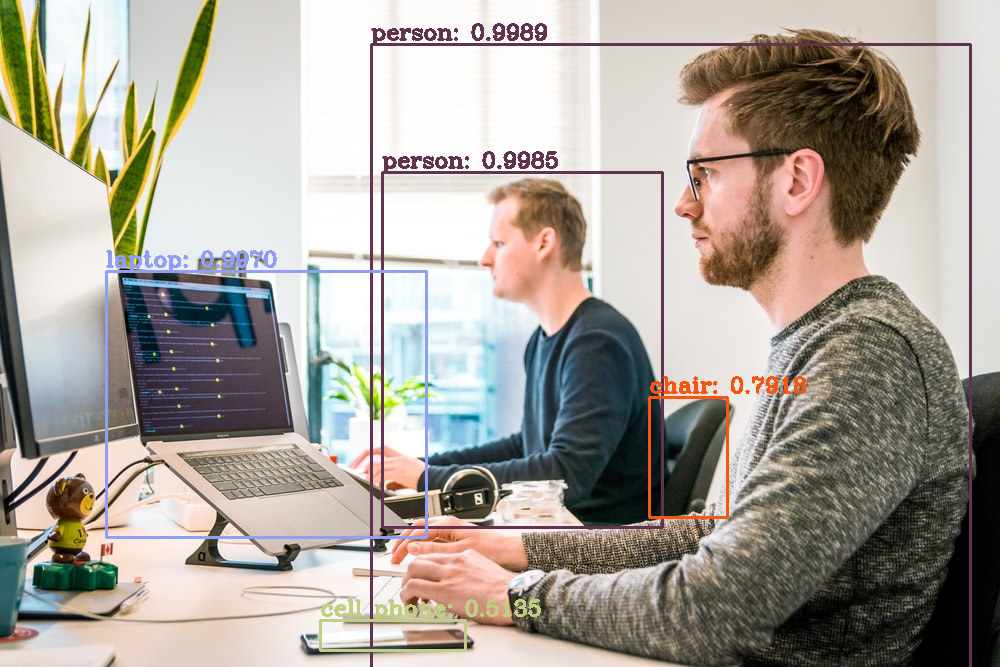

AttributeError: ignored

In [ ]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
def detectioninimage(imagepath):
    path2 = os.path.abspath('/content/drive/MyDrive/yolococo/cfg/yolov3.weights')

    # initialize minimum probability to eliminate weak predictions
    p_min = 0.5

    # threshold when applying non-maxia suppression
    thres = 0.3


    # Read image with opencv
    image = cv2.imread(imagepath) # we get image in BGR
    h, w = image.shape[:2]  # Slicing and get height, width of the image

    # image preprocessing for deep learning
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)
    print(image.shape) # (548, 821, 3)
    print(blob.shape) # (1, 3, 416, 416)

    # Create labels into list
    with open('/content/drive/MyDrive/yolococo/cfg/coco.names') as f:
        labels = [line.strip() for line in f]

    # Initialize colours for representing every detected object
    colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

    # Loading trained YOLO v3 Objects Detector
    # with the help of 'dnn' library from OpenCV
    # Reads a network model stored in Darknet model files.
    network = cv2.dnn.readNetFromDarknet('/content/drive/MyDrive/yolococo/cfg/yolov3.cfg',
                                         path2)

    # Getting only output layer names that we need from YOLO
    ln = network.getLayerNames()
    ln = [ln[i[0] - 1] for i in network.getUnconnectedOutLayers()]
    print(ln)

    # perform a forward pass of the YOLO object detector, giving us our bounding boxes
    # and associated probabilities.
    network.setInput(blob)
    output_from_network = network.forward(ln)

    # Preparing lists for detected bounding boxes, confidences and class numbers.
    bounding_boxes = []
    confidences = []
    class_numbers = []

    # Going through all output layers after feed forward pass
    for result in output_from_network:
        for detected_objects in result:
            scores = detected_objects[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > p_min:
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                # Now, from YOLO data format, we can get top left corner coordinates
                # that are x_min and y_min
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Adding results into prepared lists
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    print(bounding_boxes)
    print(confidences)
    print(class_numbers)


    # Implementing non-maximum suppression of given bounding boxes
    # With this technique we exclude some of bounding boxes if their
    # corresponding confidences are low or there is another
    # bounding box for this region with higher confidence
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences,
                               p_min, thres)

    # At-least one detection should exists
    if len(results) > 0:
        for i in results.flatten():

            # Getting current bounding box coordinates, its width and height
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

            # Preparing colour for current bounding box
            colour_box_current = colours[class_numbers[i]].tolist()

            # Drawing bounding box on the original image
            cv2.rectangle(image, (x_min, y_min),
                          (x_min + box_width, y_min + box_height),
                          colour_box_current, 2)

            # Preparing text with label and confidence for current bounding box
            text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])],
                                                   confidences[i])

            # Putting text with label and confidence on the original image
            cv2.putText(image, text_box_current, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_COMPLEX, 0.7, colour_box_current, 2)


    #cv2.namedWindow('Detections', cv2.WINDOW_NORMAL) # WINDOW_NORMAL gives window as resizable.
    cv2_imshow(image)
    #cv2.waitKey(0)
    #cv2.destroyWindow('Detections')
detectioninimage('/content/drive/MyDrive/yolococo/images/00pedxing01-superJumbo.jpg')
detectioninimage('/content/drive/MyDrive/yolococo/images/yolo_image.jpeg')
detectioninimage('/content/drive/MyDrive/yolococo/images/images (1).jpg')
detectioninimage('/content/drive/MyDrive/yolococo/images/images (2).jpg')
detectioninimage('/content/drive/MyDrive/yolococo/images/images (3).jpg')


In [ ]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from base64 import b64encode
def detectioninvideo(videopath):   
    path2 = os.path.abspath('/content/drive/MyDrive/yolococo/cfg/yolov3.weights')
    # initialize minimum probability to eliminate weak predictions
    p_min = 0.5
    
    # threshold when applying non-maxia suppression
    thres = 0.
    
    # 'VideoCapture' object and reading video from a file
    video = cv2.VideoCapture(videopath)
    
    # Preparing variable for writer
    # that we will use to write processed frames
    writer = None
    
    # Preparing variables for spatial dimensions of the frames
    h, w = None, None
    
    # Create labels into list
    with open('/content/drive/MyDrive/yolococo/cfg/coco.names') as f:
        labels = [line.strip() for line in f]
    # Initialize colours for representing every detected object
    colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')
    
    # Loading trained YOLO v3 Objects Detector
    # with the help of 'dnn' library from OpenCV
    # Reads a network model stored in Darknet model files.
    network = cv2.dnn.readNetFromDarknet('/content/drive/MyDrive/yolococo/cfg/yolov3.cfg',
                                         path2)
    
    # Getting only output layer names that we need from YOLO
    ln = network.getLayerNames()
    ln = [ln[i[0] - 1] for i in network.getUnconnectedOutLayers()]
    
    # Defining loop for catching frames
    while True:
        ret, frame = video.read()
        if not ret:
            break
    
        # Getting dimensions of the frame for once as everytime dimensions will be same
        if w is None or h is None:
            # Slicing and get height, width of the image
            h, w = frame.shape[:2]
    
        # frame preprocessing for deep learning
        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
                                     swapRB=True, crop=False)
    
        # perform a forward pass of the YOLO object detector, giving us our bounding boxes
        # and associated probabilities.
        network.setInput(blob)
        output_from_network = network.forward(ln)
    
        # Preparing lists for detected bounding boxes, confidences and class numbers.
        bounding_boxes = []
        confidences = []
        class_numbers = []
    
        # Going through all output layers after feed forward pass
        for result in output_from_network:
            for detected_objects in result:
                scores = detected_objects[5:]
                class_current = np.argmax(scores)
                confidence_current = scores[class_current]
    
                if confidence_current > p_min:
                    box_current = detected_objects[0:4] * np.array([w, h, w, h])
    
                    # Now, from YOLO data format, we can get top left corner coordinates
                    # that are x_min and y_min
                    x_center, y_center, box_width, box_height = box_current
                    x_min = int(x_center - (box_width / 2))
                    y_min = int(y_center - (box_height / 2))
    
                    # Adding results into prepared lists
                    bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                    confidences.append(float(confidence_current))
                    class_numbers.append(class_current)
    
        # Implementing non-maximum suppression of given bounding boxes
        # With this technique we exclude some of bounding boxes if their
        # corresponding confidences are low or there is another
        # bounding box for this region with higher confidence
        results = cv2.dnn.NMSBoxes(bounding_boxes, confidences,
                                   p_min, thres)
    
        # At-least one detection should exists
        if len(results) > 0:
            for i in results.flatten():
                # Getting current bounding box coordinates, its width and height
                x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
                box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
    
                # Preparing colour for current bounding box
                colour_box_current = colours[class_numbers[i]].tolist()
    
                # Drawing bounding box on the original image
                cv2.rectangle(frame, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 2)
    
                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])],
                                                       confidences[i])
    
                # Putting text with label and confidence on the original image
                cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_COMPLEX, 0.7, colour_box_current, 2)
    
        """Store proccessed frames into result video."""
        # Initialize writer
        if writer is None:
            resultVideo = cv2.VideoWriter_fourcc(*'mp4v')
    
            # Writing current processed frame into the video file
            writer = cv2.VideoWriter('/content/drive/MyDrive/yolococo/videos/result-video.mp4', resultVideo, 30,
                                     (frame.shape[1], frame.shape[0]), True)
    
        # Write processed current frame to the file
        writer.write(frame)
    
    # Releasing video reader and writer
    video.release()
    writer.release()

    mp4 = open('/content/drive/MyDrive/yolococo/videos/result-video.mp4','rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML("""
    <video width=400 controls>
      <source src="%s" type="video/mp4">
      </video>
      """ % data_url)

detectioninvideo('/content/drive/MyDrive/yolococo/videos/video.mp4')

In [ ]:
!pip install -U kora
from kora.drive import upload_public
url = upload_public('/content/drive/MyDrive/yolococo/videos/result-video.mp4')
url = upload_public('/content/drive/MyDrive/yolococo/videos/pedestrian video.mp4')
# then display it
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")